Dataset generated and saved as cp_training_dataset.csv.
Cp values calculated and saved in cp_training_dataset_with_cp.csv.


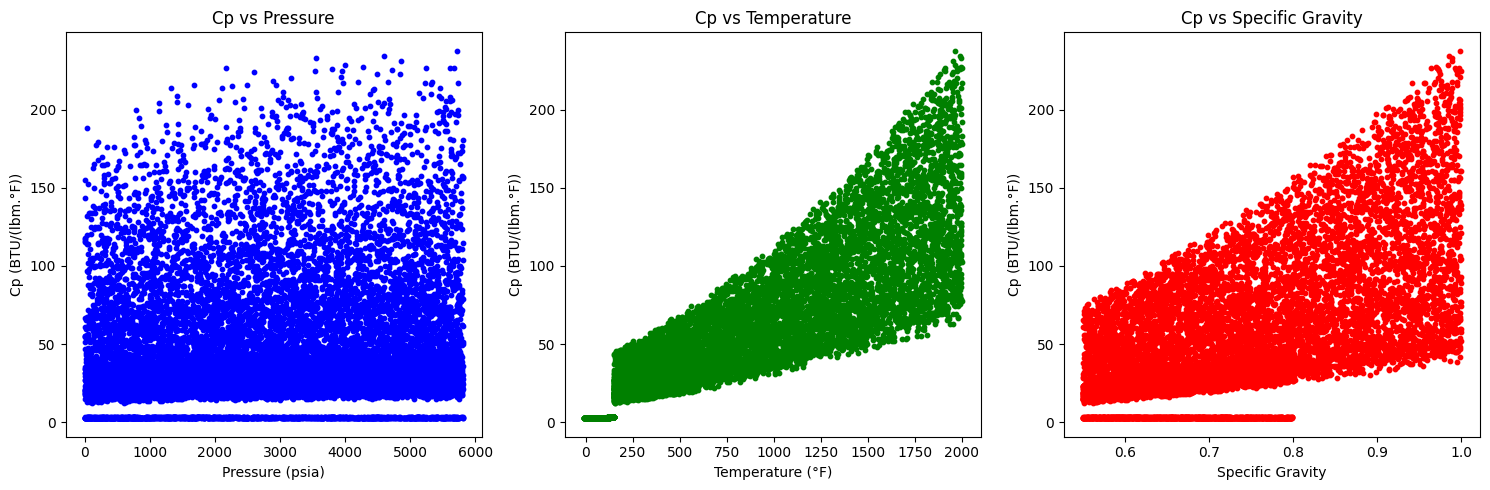

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3313.0864 - mae: 41.6575 - val_loss: 1975.4338 - val_mae: 25.6092
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1613.3463 - mae: 22.2756 - val_loss: 1286.4677 - val_mae: 17.5830
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1104.1517 - mae: 16.8447 - val_loss: 887.2183 - val_mae: 13.0318
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 824.6221 - mae: 14.2536 - val_loss: 638.6760 - val_mae: 10.4334
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 579.0632 - mae: 11.9450 - val_loss: 474.5984 - val_mae: 8.5303
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 406.7934 - mae: 10.3196 - val_loss: 357.1356 - val_mae: 7.4392
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 349.5649 - mae: 9.8933 - val_loss: 273.6909 - val_mae: 6.1778
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 273.2717 - mae: 9.2928 - val_loss: 215.4094 - val_mae: 5.5957
E

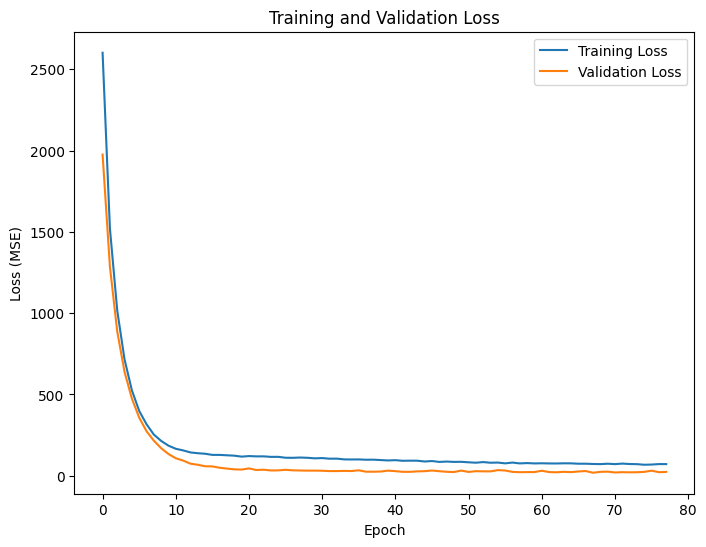


--- Prediction on New Data ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
   Pressure (psia)  Temperature (°F)  Specific Gravity  Ppc (psia)       Ppr  \
0             1500               500              0.65   660.90625  2.269611   
1             3000               800              0.75   660.98125  4.538707   
2             4500              1200              0.85   654.03525  6.880363   

   Predicted Cp (BTU/(lbm.°F))  
0                    27.522779  
1                    48.845764  
2                   101.545326  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# --- Data Generation ---
def generate_cp_dataset(n_samples=15000, random_seed=42):
    """
    Generates a synthetic dataset for specific heat capacity (Cp) prediction
    based on Karem and Omeke (2011) and Esmaelli et al. (2022) correlations.
    """
    np.random.seed(random_seed)

    # Define correlation ranges
    ko_temp_range = (150, 2000)  # °F
    ko_sg_range = (0.55, 1)

    es_pressure_low_range = (0, 1000)  # psia
    es_temp_low_range = (-10, 600)  # °F
    es_pressure_high_range = (1000, 5806)  # psia
    es_temp_high_range = (68, 600)  # °F
    es_sg_range = (0.55, 0.8)

    all_samples = []

    # Generate samples for Karem and Omeke (2011) correlation
    for _ in range(n_samples // 2):
        pressure = np.random.uniform(0, 5806)  # Pressure can be any value within the overall range
        temperature = np.random.uniform(ko_temp_range[0], ko_temp_range[1])
        specific_gravity = np.random.uniform(ko_sg_range[0], ko_sg_range[1])
        all_samples.append([pressure, temperature, specific_gravity])

    # Generate samples for Esmaelli et al. (2022) correlation
    for _ in range(n_samples // 2):
        pressure = np.random.uniform(es_pressure_low_range[0], es_pressure_high_range[1])
        if pressure <= 1000:
            temperature = np.random.uniform(es_temp_low_range[0], es_temp_low_range[1])
        else:
            temperature = np.random.uniform(es_temp_high_range[0], es_temp_high_range[1])
        specific_gravity = np.random.uniform(es_sg_range[0], es_sg_range[1])
        all_samples.append([pressure, temperature, specific_gravity])

    df = pd.DataFrame(all_samples, columns=["Pressure (psia)", "Temperature (°F)", "Specific Gravity"])
    df.to_csv("cp_training_dataset.csv", index=False)
    print("Dataset generated and saved as cp_training_dataset.csv.")
    return df

# --- Correlation Functions ---
def calculate_ppc(specific_gravity):
    """
    Calculates pseudo-critical pressure (Ppc) using Standing's correlation (1977).
    """
    if specific_gravity < 0.75:
        return 667 + 15 * specific_gravity - 37.5 * specific_gravity**2
    else:
        return 706 - 51.7 * specific_gravity - 11.1 * specific_gravity**2

def karem_omeke_cp(pressure, temperature, specific_gravity, ppr):
    """
    Calculates Cp using the Karem and Omeke (2011) correlation.
    Temperature must be in Rankine (°F + 459.67).
    """
    temperature_r = temperature + 459.67

    D0 = 6.0050 * specific_gravity**2 - 0.0416 * specific_gravity + 6.1719
    D1 = -1.3498e-2 * specific_gravity**2 + 4.0381e-2 * specific_gravity - 1.1206e-2
    D2 = 8.6856e-6 * specific_gravity**2 - 2.0784e-6 * specific_gravity + 9.2702e-6
    D3 = -1.8749e-9 * specific_gravity**2 + 4.0319e-9 * specific_gravity - 2.1300e-9

    temp_term = D0 + D1 * temperature_r + D2 * temperature_r**2 + D3 * temperature_r**3
    pressure_term = 0.0001561 * ppr**3 - 0.005435 * ppr**2 + 0.060528 * ppr + 0.94251
    cp = temp_term * pressure_term * (specific_gravity / 0.7)
    return cp

def esmaelli_cp(pressure, temperature, specific_gravity):
    """
    Calculates Cp using the Esmaelli et al. (2022) correlation.
    Temperature must be in Rankine (°F + 459.67).
    """
    C1, C2, C3, C4, C5, C6, C7, C8, C9, C10 = (
        6.43165, -2518.780, -0.000248903, 351228, 0.000000016047,
        0.10704, -958039, 0.000000000000156699, -0.00000930984, 17.43982
    )
    temperature_r = temperature + 459.67
    S = pressure * specific_gravity**1.25
    cp = (C1 + C2 / temperature_r + C3 * S + C4 / temperature_r**2 + C5 * S**2 +
          C6 * S / temperature_r + C7 / temperature_r**3 + C8 * S**3 +
          C9 * S**2 / temperature_r + C10 * S / temperature_r**2)
    return cp

def calculate_cp_values(df):
    """
    Calculates Cp values for each row in the DataFrame based on applicable correlations.
    Adds Ppc, Ppr, and Cp columns to the DataFrame.
    """
    cp_values = []
    ppc_values = []
    ppr_values = []

    for index, row in df.iterrows():
        pressure = row["Pressure (psia)"]
        temperature = row["Temperature (°F)"]
        specific_gravity = row["Specific Gravity"]

        pseudo_critical_pressure = calculate_ppc(specific_gravity)
        ppc_values.append(pseudo_critical_pressure)

        ppr = pressure / pseudo_critical_pressure
        ppr_values.append(ppr)

        cp = None
        # Apply Karem and Omeke (2011) correlation if within its ranges
        if 150 <= temperature <= 2000 and 0.55 <= specific_gravity <= 1:
            cp = karem_omeke_cp(pressure, temperature, specific_gravity, ppr)
        # Apply Esmaelli et al. (2022) correlation if within its ranges
        elif 0.55 <= specific_gravity <= 0.8:
            if (-10 <= temperature <= 600 and 0 <= pressure <= 1000) or \
               (68 <= temperature <= 600 and 1000 < pressure <= 5806):
                cp = esmaelli_cp(pressure, temperature, specific_gravity)
        cp_values.append(cp)

    df.insert(3, "Ppc (psia)", ppc_values)
    df.insert(4, "Ppr", ppr_values)
    df["Cp (BTU/(lbm.°F))"] = cp_values
    df.dropna(subset=["Cp (BTU/(lbm.°F))"], inplace=True) # Remove rows where Cp couldn't be calculated
    df.to_csv("cp_training_dataset_with_cp.csv", index=False)
    print("Cp values calculated and saved in cp_training_dataset_with_cp.csv.")
    return df

# --- Data Visualization ---
def visualize_data_distribution(df):
    """
    Generates scatter plots to visualize the relationship between Cp and
    Pressure, Temperature, and Specific Gravity.
    """
    plt.figure(figsize=(15, 5))

    # Cp vs Pressure
    plt.subplot(1, 3, 1)
    plt.scatter(df["Pressure (psia)"], df["Cp (BTU/(lbm.°F))"], color='blue', s=10)
    plt.title("Cp vs Pressure")
    plt.xlabel("Pressure (psia)")
    plt.ylabel("Cp (BTU/(lbm.°F))")

    # Cp vs Temperature
    plt.subplot(1, 3, 2)
    plt.scatter(df["Temperature (°F)"], df["Cp (BTU/(lbm.°F))"], color='green', s=10)
    plt.title("Cp vs Temperature")
    plt.xlabel("Temperature (°F)")
    plt.ylabel("Cp (BTU/(lbm.°F))")

    # Cp vs Specific Gravity
    plt.subplot(1, 3, 3)
    plt.scatter(df["Specific Gravity"], df["Cp (BTU/(lbm.°F))"], color='red', s=10)
    plt.title("Cp vs Specific Gravity")
    plt.xlabel("Specific Gravity")
    plt.ylabel("Cp (BTU/(lbm.°F))")

    plt.tight_layout()
    plt.show()

# --- Model Training and Evaluation ---
def build_and_train_model(X_train, y_train, X_val, y_val):
    """
    Builds, compiles, and trains a deep neural network.
    """
    model = Sequential([
        Dense(64, input_shape=(X_train.shape[1],), activation='tanh', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(128, activation='tanh', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(64, activation='tanh', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(1, activation='linear')  # Linear output for regression
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])
    return model, history

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the trained model on the test set and prints metrics.
    """
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Mean Absolute Error: {mae:.4f}")
    y_pred = model.predict(X_test).flatten()
    r2 = r2_score(y_test, y_pred)
    print(f"Test R²: {r2:.4f}")
    return loss, mae, r2

def plot_training_history(history):
    """
    Plots the training and validation loss over epochs.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.show()

# --- Main Execution Flow ---
if __name__ == "__main__":
    # 1. Data Generation
    initial_df = generate_cp_dataset()

    # 2. Calculate Cp values and feature engineering
    processed_df = calculate_cp_values(initial_df.copy()) # Use a copy to avoid modifying initial_df if needed elsewhere

    # 3. Visualize Data Distribution
    visualize_data_distribution(processed_df)

    # 4. Data Splitting and Scaling
    features = ["Pressure (psia)", "Temperature (°F)", "Specific Gravity", "Ppc (psia)", "Ppr"]
    target = "Cp (BTU/(lbm.°F))"

    X = processed_df[features].values
    y = processed_df[target].values

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # 5. Build and Train Model
    model, history = build_and_train_model(X_train_scaled, y_train, X_val_scaled, y_val)

    # 6. Evaluate Model
    print("\n--- Model Evaluation ---")
    evaluate_model(model, X_test_scaled, y_test)
    plot_training_history(history)

    # 7. Predict on New Data
    print("\n--- Prediction on New Data ---")
    new_data_input = pd.DataFrame({
        "Pressure (psia)": [1500, 3000, 4500],
        "Temperature (°F)": [500, 800, 1200],
        "Specific Gravity": [0.65, 0.75, 0.85]
    })

    # Calculate Ppc and Ppr for new data
    new_data_input["Ppc (psia)"] = new_data_input["Specific Gravity"].apply(calculate_ppc)
    new_data_input["Ppr"] = new_data_input["Pressure (psia)"] / new_data_input["Ppc (psia)"]

    # Ensure the order of columns matches the training data
    X_new_scaled = scaler.transform(new_data_input[features].values)
    y_new_pred = model.predict(X_new_scaled).flatten()
    new_data_input["Predicted Cp (BTU/(lbm.°F))"] = y_new_pred

    print(new_data_input)
